**<font color = black size=6>实验四:模型评估</font>**

**<font color = blue size=4>第一部分:数据集划分</font>**

In [29]:
# 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
import warnings
import random
warnings.filterwarnings('ignore')


<span style="color:purple">给定一个完整的数据集，尚未划分训练集和测试集，我们需要手动实现训练集和测试集的划分:</span>

<span style="color:purple">我们继续使用iris数据集(iris.csv)，这次我们引入了具有4个特征 (花萼长度($x_1$)，花萼宽度 ($x_2$),花瓣长度 ($x_3$),花瓣宽度 ($x_4$))和两个标签 (Setosa，Versicolour)的100个样本数据，其中每类标签的样本占50%。我们需要将其划分为训练集和测试集，其中测试集中的样本数量占总数量的30%(也就是30个)，且测试集中每个标签的样本各占50%</span>

<span style="color:purple">1) 留出法</span>

<span style="color:purple">我们通过随机选择样本的方式将数据分割为训练集和测试集，并保持两种标签的数据的数量一致</span>

In [30]:
#通过pandas将csv文件转换为dataframe格式后进行操作
df = pd.read_csv('iris.csv')

#将label标签内容从字符串替换为数值
df['Species'] = df['Species'].map({'setosa': 0, 'virginica': 1}).fillna(-1)

# 获取特征和标签列
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# 计算每个类别需要分配给测试集的样本数量的比例，假设为 30%
test_ratio = 0.3

# 计算每个类别需要分配给测试集的样本数量
test_samples_per_class = (labels.value_counts() * test_ratio).astype(int)

# 初始化测试集和训练集
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# 根据标签的分布进行采样
for label, count in test_samples_per_class.items():
    class_samples = df[df['Species'] == label].sample(n=count, random_state=42)
    test_data = test_data.append(class_samples)
    train_data = train_data.append(df[df['Species'] == label].drop(class_samples.index))

# 获取训练集和测试集的特征和标签
train_features = train_data.iloc[:, :-1]
train_labels = train_data.iloc[:, -1]
test_features = test_data.iloc[:, :-1]
test_labels = test_data.iloc[:, -1]

# 打印训练集和测试集大小
print("Train data number: ", len(train_data))
print("Test data number: ", len(test_data))

#打印训练集和测试集
print("Train data : ", np.array(train_data))
print("Test data : ", np.array(test_data))

Train data number:  70
Test data number:  30
Train data :  [[5.1 3.5 1.4 0.2 0. ]
 [4.9 3.  1.4 0.2 0. ]
 [4.7 3.2 1.3 0.2 0. ]
 [5.4 3.9 1.7 0.4 0. ]
 [4.6 3.4 1.4 0.3 0. ]
 [5.  3.4 1.5 0.2 0. ]
 [4.9 3.1 1.5 0.1 0. ]
 [5.4 3.7 1.5 0.2 0. ]
 [4.8 3.4 1.6 0.2 0. ]
 [5.8 4.  1.2 0.2 0. ]
 [5.7 4.4 1.5 0.4 0. ]
 [5.4 3.9 1.3 0.4 0. ]
 [5.7 3.8 1.7 0.3 0. ]
 [5.4 3.4 1.7 0.2 0. ]
 [5.1 3.7 1.5 0.4 0. ]
 [4.6 3.6 1.  0.2 0. ]
 [5.1 3.3 1.7 0.5 0. ]
 [4.8 3.4 1.9 0.2 0. ]
 [5.2 3.5 1.5 0.2 0. ]
 [5.2 3.4 1.4 0.2 0. ]
 [4.7 3.2 1.6 0.2 0. ]
 [5.4 3.4 1.5 0.4 0. ]
 [5.5 4.2 1.4 0.2 0. ]
 [4.9 3.1 1.5 0.2 0. ]
 [5.  3.2 1.2 0.2 0. ]
 [5.5 3.5 1.3 0.2 0. ]
 [4.4 3.  1.3 0.2 0. ]
 [5.  3.5 1.3 0.3 0. ]
 [4.5 2.3 1.3 0.3 0. ]
 [4.4 3.2 1.3 0.2 0. ]
 [5.  3.5 1.6 0.6 0. ]
 [5.1 3.8 1.9 0.4 0. ]
 [5.1 3.8 1.6 0.2 0. ]
 [4.6 3.2 1.4 0.2 0. ]
 [5.  3.3 1.4 0.2 0. ]
 [6.3 3.3 6.  2.5 1. ]
 [5.8 2.7 5.1 1.9 1. ]
 [7.1 3.  5.9 2.1 1. ]
 [7.6 3.  6.6 2.1 1. ]
 [4.9 2.5 4.5 1.7 1. ]
 [7.3 2.9 6.3 1.8 1. 

<span style="color:purple">2) 交叉验证法</span>

<span style="color:purple">我们将数据集分割为k个大小相等且标签数量类似的子数据集，每个迭代中选取一个子数据集作为测试集，剩余k-1个组成训练集，并保持两种标签的数据的数量一致</span>

In [31]:
df = pd.read_csv('iris.csv')

#将label标签内容从字符串替换为数值
df['Species'] = df['Species'].map({'setosa': 0, 'virginica': 1}).fillna(-1)

# 获取特征和标签列
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# 将数据按照标签分为两类
class_0_samples = df[df['Species'] == 0]
class_1_samples = df[df['Species'] == 1]

# 将每一类别的样本随机排序
class_0_samples = class_0_samples.sample(frac=1, random_state=42)
class_1_samples = class_1_samples.sample(frac=1, random_state=42)


# 进行 k 折交叉验证
k = 5

# 初始化训练集和测试集的列表
train_data = []
test_data = []

for i in range(k):
    # 初始化当前折的训练集和测试集
    train_fold = pd.DataFrame()
    test_fold = pd.DataFrame()

    # 计算当前折中每个类别的样本数量
    class_0_fold_size = len(class_0_samples) // k
    class_1_fold_size = len(class_1_samples) // k
    

    # 添加当前折中每个类别的样本到测试集
    test_fold = test_fold.append(class_0_samples[i * class_0_fold_size: (i + 1) * class_0_fold_size])
    test_fold = test_fold.append(class_1_samples[i * class_1_fold_size: (i + 1) * class_1_fold_size])
    
    # 添加剩余样本到训练集
    train_fold = df.drop(test_fold.index)

    # 打乱训练集和测试集的顺序，以便更好的随机性
    train_fold = train_fold.sample(frac=1, random_state=42)
    test_fold = test_fold.sample(frac=1, random_state=42)

    # 将当前折的训练集和测试集添加到列表
    train_data.append(train_fold)
    test_data.append(test_fold)

# 打印每一折的测试集索引，可以看到均为不重复样本
for i in range(k):
    print("第", i+1, "折的测试集: ", (test_data[i].index))

第 1 折的测试集:  Int64Index([13, 75, 98, 39, 32, 48, 89, 45, 82, 76, 95, 30, 19, 69, 17, 80, 25,
            63, 67, 26],
           dtype='int64')
第 2 折的测试集:  Int64Index([12, 96, 56, 4, 47, 6, 54, 8, 97, 91, 58, 37, 15, 65, 3, 87, 46, 62,
            53, 41],
           dtype='int64')
第 3 折的测试集:  Int64Index([9, 77, 50, 16, 33, 0, 66, 34, 83, 94, 84, 24, 5, 55, 31, 74, 27,
            59, 81, 44],
           dtype='int64')
第 4 折的测试集:  Int64Index([29, 85, 52, 11, 23, 2, 61, 1, 73, 93, 51, 36, 40, 90, 21, 86, 35,
            79, 71, 43],
           dtype='int64')
第 5 折的测试集:  Int64Index([10, 64, 57, 22, 28, 7, 72, 49, 78, 92, 99, 18, 38, 88, 20, 68, 14,
            60, 70, 42],
           dtype='int64')


<span style="color:purple">3) 自助法</span>

<span style="color:purple">我们使用有放回采样的方式，每次选取选取一个样本加入到训练集，抽取样本数量(100)次后，将未被选择的样本组成测试集</span>

In [32]:
df = pd.read_csv('iris.csv')

#将label标签内容从字符串替换为数值
df['Species'] = df['Species'].map({'setosa': 0, 'virginica': 1}).fillna(-1)

# 获取特征和标签列
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# 创建自助样本集
num_samples = df.shape[0]
train_data = []
test_data = []

for i in range(num_samples):
    index = random.randint(0, num_samples-1)
    train_data.append(df.iloc[index])

# 创建测试集（排除训练集中已存在的样本）
for _, row in df.iterrows():
    is_in_train_data = False
    for train_row in train_data:
        if row.equals(train_row):
            is_in_train_data = True
            break
    if not is_in_train_data:
        test_data.append(row)

# 打印训练集和测试集大小
print("训练集大小: ", len(train_data))
print("测试集大小: ", len(test_data))


训练集大小:  100
测试集大小:  36


**<font color = blue size=4>第二部分:性能度量</font>**

<span style="color:purple">1) 回归任务:</span>

<span style="color:purple">均方误差(MSE): 计算模型的预测 $\hat{Y}$ 与真实标签 $Y$ 的接近程度</span>

给定一组测试集样本$D$ = \{$(x_1,y_1),(x_2,y_2), ... ,(x_m,y_m)$\},其中$x_i$为样本$i$的特征值,$y_i$为样本$i$的标签值, $f$为训练的模型,该模型$f$在$D$的均方误差为$$E(f;D) = \frac{1}{m}\sum_{i=1}^{m}{(f(x_i)-y_i)^2}$$

<span style="color:purple">2)分类任务:</span>

<span style="color:purple">2.1)错误率: 分类错误样本占比</span>

给定一组测试集样本$D$ = \{$(x_1,y_1),(x_2,y_2), ... ,(x_m,y_m)$\}, 其中$x_i$为样本$i$的特征值, $y_i$为样本$i$的真实标签, $f$为训练的模型, $f(x_i)$为样本$i$的预测标签, 该模型$f$在$D$的错误率为$$E(f;D) = \frac{1}{m}\sum_{i=1}^{m}{Ⅱ(f(x_i)\neq y_i)}$$

<span style="color:purple">2.2)精确率: 分类正确样本占比</span>

给定一组测试集样本$D$ = \{$(x_1,y_1),(x_2,y_2), ... ,(x_m,y_m)$\}, 其中$x_i$为样本$i$的特征值, $y_i$为样本$i$的真实标签, $f$为训练的模型, $f(x_i)$为样本i的预测标签, 该模型$f$在$D$的精度为$$acc(f;D) = \frac{1}{m}\sum_{i=1}^{m}{Ⅱ(f(x_i) = y_i)} = 1 - E(f;D)$$

<span style="color:purple">2.3)查准率和查全率: 正例被预测出来的比率和预测出来的正例中正确的比率</span>

给定一组测试集样本$D$ = \{$(x_1,y_1),(x_2,y_2), ... ,(x_m,y_m)$\}, 其中$x_i$为样本$i$的特征值, $y_i$为样本$i$的真实标签, $f$为训练的模型, $f(x_i)$为样本i的预测标签.

我们假定该类样本中label为1(正例)和0(反例):

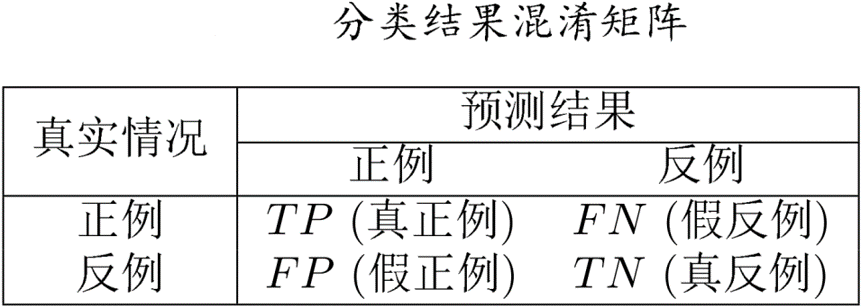

TP(真正例):$$\sum_{i=1}^{m}{Ⅱ(y_i=1 \quad \&\&\quad (f(x_i)= y_i))},$$

FP(假正例):$$\sum_{i=1}^{m}{Ⅱ(y_i=1 \quad \&\&\quad (f(x_i)\neq y_i))},$$

FN(假反例):$$\sum_{i=1}^{m}{Ⅱ(y_i=0 \quad \&\&\quad (f(x_i)\neq y_i))},$$

其中查准率(precision):$$\frac{TP}{TP+FP},$$

查全率(recall):$$\frac{TP}{TP+FN}.$$



<span style="color:purple">2.4)P-R曲线: 根据模型的预测结果按正例可能性大小对样例进行排序，并逐个把样本作为正例进行预测，则可以得到查准率-查全率曲线</span>

计算出所有用户的正例可能性:$P(y=1|x;w)$,并进行排序

从高到低以每个用户的正例可能性为【阈值】，根据$\hat{Y}=1$, if $P(y=1|x;w) \geq 【阈值】$，得到一个坐标点(precision,recall)

记录每个坐标点(precision,recall)的F1度量: $F1 = \frac{2*P*R}{P+R}$

最后将得到的所有(precision,recall)画成折线图

给出一个简易的折线图的画图例子

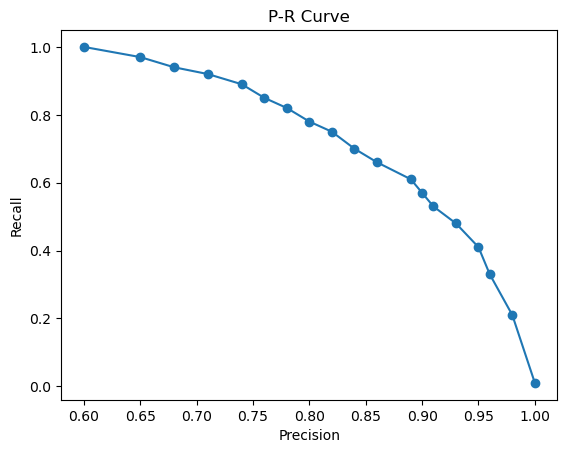

In [33]:
thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
recall     = [1.00, 0.97, 0.94, 0.92, 0.89, 0.85, 0.82, 0.78, 0.75, 0.70, 0.66, 0.61, 0.57, 0.53, 0.48, 0.41, 0.33, 0.21, 0.01]
precision  = [0.60, 0.65, 0.68, 0.71, 0.74, 0.76, 0.78, 0.80, 0.82, 0.84, 0.86, 0.89, 0.9, 0.91, 0.93, 0.95, 0.96, 0.98, 1.00]


plt.plot(precision,recall, marker='o')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('P-R Curve')
plt.show()

<span style="color:purple">2.5)ROC曲线: 根据模型的预测结果按正例可能性大小对样例进行排序，并逐个把样本作为正例进行预测，得到一组(FPR,TPR)，进而得到ROC曲线</span>

其中$TPR=\frac{TP}{TP+FN}$,$FPR=\frac{FP}{TN+FP}.$

**<font color = blue size=4>第四部分:课堂实验</font>**

我们引入了一个骨科患者的生物力学特征数据集(illness.csv)，每个患者在数据集中由六个生物力学属性表示，这些属性分别为pelvic_incidence（盆腔发病率）、pelvic_tilt numeric（骨盆倾斜）、lumbar_lordosis_angle（腰椎前凸角）、sacral_slope（骶骨斜率）、pelvic_radius（骨盆桡骨）、pelvic_radius（脊椎滑脱分级), 对应的标签则为是否为椎间盘疝气和脊椎滑脱(normal和abnormal).

该数据集共有310个样本，但并没有划分训练集和测试集.

<span style="color:purple">1)导入数据集,根据数据信息定义逻辑回归的模型</span>

In [34]:
# 定义逻辑回归模型

# 添加全1的特征量
def add_col_1(df:pd.DataFrame):
    df['x0'] = np.ones((df.shape[0],1),dtype=int)
    return df

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 定义损失函数
def loss_function(X, y, w):
    m = X.shape[0]
    h = sigmoid(X.dot(w))
    loss = (-1/m) * (y.T.dot(np.log(h)) + (1-y).T.dot(np.log(1-h)))
    return loss

# 定义梯度计算函数
def compute_gradient(X, y, w):
    m = X.shape[0]
    h = sigmoid(X.dot(w)).reshape(-1,1)
    gradient = (1/m) * (np.sum(X.T.dot(h - y),axis=1))
    return gradient

def train_model(data:pd.DataFrame,w,learning_rate,num_iter,min_step)->list:
    
    x = data[['x0','pelvic_incidence','pelvic_tilt numeric','lumbar_lordosis_angle',
              'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']].to_numpy().astype(float)
    y = data[['class']].to_numpy().astype(float)
    
    # 迭代计算
    for i in range(num_iter):
        
        # 计算梯度
        gradient = compute_gradient(x, y, w)
        # 当迭代的差异量小于一个值，停止迭代
        if(np.abs(learning_rate * gradient).max() < min_step):
            print('break')
            break
        # step forward
        w = w - learning_rate * gradient
    
    return w

# 计算LOSS值
def cal_loss_predict(data:pd.DataFrame,w):

    x = data[['x0','pelvic_incidence','pelvic_tilt numeric','lumbar_lordosis_angle',
              'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']].to_numpy().astype(float)
    y = data[['class']].to_numpy().astype(float)
    y_predict = 1/(1+np.exp(-x@w))

    # 计算概率函数
    loss = loss_function(x,y,w)

    return loss,y_predict


<span style="color:purple">2)请分别使用三种数据划分方式(留出法、交叉验证法、自助法)划分出训练集和测试集</span>

In [35]:
#留出法
def set_aside_method():
    # 读取文件
    df = pd.read_csv('illness.csv')
    print(df.columns)
    #将label标签内容从字符串替换为数值
    df['class'] = df['class'].map({'Normal': 0, 'Abnormal': 1}).fillna(-1)

    # 获取特征和标签列
    features = df.iloc[:, :-1]
    labels = df.iloc[:, -1]

    # 每个类别测试集的样本数量的比例，30%
    test_ratio = 0.3

    # 计算每个类别需要分配给测试集的样本数量
    test_samples_per_class = (labels.value_counts() * test_ratio).astype(int)
    print('test_samples_per_class\n',test_samples_per_class)

    # 初始化测试集和训练集
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # 采样
    for label, count in test_samples_per_class.items():
        class_samples = df[df['class'] == label].sample(n=count, random_state=42)
        test_data = test_data.append(class_samples)
        train_data = train_data.append(df[df['class'] == label].drop(class_samples.index))

    # # 获取训练集和测试集的特征和标签
    # train_features = train_data.iloc[:, :-1]
    # train_labels = train_data.iloc[:, -1]
    # test_features = test_data.iloc[:, :-1]
    # test_labels = test_data.iloc[:, -1]

    # 打印训练集和测试集大小
    print("Train data number: ", len(train_data))
    print("Test data number: ", len(test_data))

    #打印训练集和测试集
    print("Train data : \n", np.array(train_data[:5]))
    print("Test data : \n", np.array(test_data[:5]))
    
    return train_data,test_data


In [36]:
#交叉验证法
def cross_validation_method(k:int):
    
    # 读取文件
    df = pd.read_csv('illness.csv')
    print(df.columns)
    #将label标签内容从字符串替换为数值
    df['class'] = df['class'].map({'Normal': 0, 'Abnormal': 1}).fillna(-1)

    # 获取特征和标签列
    features = df.iloc[:, :-1]
    labels = df.iloc[:, -1]

    # 将数据按照标签分为两类
    class_0_samples = df[df['class'] == 0]
    class_1_samples = df[df['class'] == 1]

    # 将每一类别的样本随机排序
    class_0_samples = class_0_samples.sample(frac=1, random_state=42)
    class_1_samples = class_1_samples.sample(frac=1, random_state=42)

    # 初始化训练集和测试集的列表
    train_data = []
    test_data = []

    for i in range(k):
        # 初始化当前折的训练集和测试集
        train_fold = pd.DataFrame()
        test_fold = pd.DataFrame()

        # 计算当前折中每个类别的样本数量
        class_0_fold_size = len(class_0_samples) // k
        class_1_fold_size = len(class_1_samples) // k
        
        # 添加当前折中每个类别的样本到测试集
        test_fold = test_fold.append(class_0_samples[i * class_0_fold_size: (i + 1) * class_0_fold_size])
        test_fold = test_fold.append(class_1_samples[i * class_1_fold_size: (i + 1) * class_1_fold_size])
        
        # 添加剩余样本到训练集
        train_fold = df.drop(test_fold.index)

        # 打乱训练集和测试集的顺序
        train_fold = train_fold.sample(frac=1, random_state=42)
        test_fold = test_fold.sample(frac=1, random_state=42)

        # 将当前折的训练集和测试集添加到列表
        train_data.append(train_fold)
        test_data.append(test_fold)

    # 打印每一折的测试集索引，可以看到均为不重复样本
    for i in range(k):
        print("第", i+1, "折的测试集: ", (test_data[i].index))
    
    return train_data,test_data

# cross_validation_method(4)

In [37]:
#自助法
def boot_strap_method():
    
    df = pd.read_csv('illness.csv')

    #将label标签内容从字符串替换为数值
    df['class'] = df['class'].map({'Normal': 0, 'Abnormal': 1}).fillna(-1)

    # 获取特征和标签列
    features = df.iloc[:, :-1]
    labels = df.iloc[:, -1]

    # 创建自助样本集
    num_samples = df.shape[0]
    train_data = []
    test_data = []

    for i in range(num_samples):
        index = random.randint(0, num_samples-1)
        train_data.append(df.iloc[index])

    # 创建测试集（排除训练集中已存在的样本）
    for _, row in df.iterrows():
        is_in_train_data = False
        for train_row in train_data:
            if row.equals(train_row):
                is_in_train_data = True
                break
        if not is_in_train_data:
            test_data.append(row)
            

    # 打印训练集和测试集大小
    print("训练集大小: ", len(train_data))
    print("测试集大小: ", len(test_data))
    print("数据大小: ", df.shape[0])
    
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    
    return train_data,test_data
    
# boot_strap_method()


<span style="color:purple">3)请分别在三种数据划分方式(留出法、交叉验证法、自助法)所划分出训练集和测试集下训练逻辑回归模型,并测试错误率\精度</span>

In [38]:
# 计算错误率与精度
def cal_err_acc_rate(test_data:pd.DataFrame):
    m = float(len(test_data))
    acc_num = len(test_data[test_data['class']==test_data['predict']])
    acc = acc_num/m
    err = 1 - acc
    return err, acc



In [39]:
#留出法测试精度
train_data,test_data = set_aside_method()
w = [0,0,0,0,0,0,0]
train_data = add_col_1(train_data)
test_data = add_col_1(test_data)

# 梯度下降计算
# 参数设置
learning_rate = 0.1
num_iter = 100000
min_step = 0.0001

# 训练模型
w = train_model(train_data,w,learning_rate,num_iter,min_step)
print('参数w',w)

# 计算loss与预测结果
loss, predict = cal_loss_predict(test_data,w)
print('loss:',loss)

test_data['predict'] = np.where(predict>=0.5,1,0)
print('predict',test_data[:10])

err_rate, acc_rate = cal_err_acc_rate(test_data)
print('err_rate:\n',err_rate)
print('acc_rate:\n',acc_rate)

set_aside_err_rate = err_rate
set_aside_acc_rate = acc_rate

Index(['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')
test_samples_per_class
 1    63
0    30
Name: class, dtype: int32
Train data number:  217
Test data number:  93
Train data : 
 [[ 63.0278175   22.55258597  39.60911701  40.47523153  98.67291675
   -0.25439999   1.        ]
 [ 39.05695098  10.06099147  25.01537822  28.99595951 114.4054254
    4.56425864   1.        ]
 [ 68.83202098  22.21848205  50.09219357  46.61353893 105.9851355
   -3.53031731   1.        ]
 [ 69.29700807  24.65287791  44.31123813  44.64413017 101.8684951
   11.21152344   1.        ]
 [ 49.71285934   9.65207488  28.317406    40.06078446 108.1687249
    7.91850062   1.        ]]
Test data : 
 [[ 50.81926781  15.40221253  42.52893886  35.41705528 112.192804
   10.86956554   1.        ]
 [ 56.66829282  13.45820343  43.76970978  43.21008939  93.69220863
   21.10812135   1.        ]
 [ 76.32600187  4

In [40]:
#交叉验证法
#每次选用一个子集作为测试集，剩余k-1个子集的并集作为训练集，所以需要每轮都进行测试
#可以使用k个轮次的精度的平均精度作为本方法的最终精度

# 设置为10折
train_data,test_data = cross_validation_method(k=10)

# 参数设置
learning_rate = 0.1
num_iter = 100000
min_step = 0.0001
w = [0,0,0,0,0,0,0]

all_err_rate = []
all_acc_rate = []

# each cross
for i in range(len(train_data)):

    _train_data = train_data[i]
    _test_data = test_data[i]
    # 添加为1的列
    _train_data = add_col_1(_train_data)
    _test_data = add_col_1(_test_data)

    # 梯度下降计算
    # 训练模型
    w = train_model(_train_data,w,learning_rate,num_iter,min_step)
    print('参数w',w)

    # 计算loss与预测结果
    loss, predict = cal_loss_predict(_test_data,w)
    print('loss:',loss)

    _test_data['predict'] = np.where(predict>=0.5,1,0)
    # print('predict',test_data[:10])

    err_rate, acc_rate = cal_err_acc_rate(_test_data)
    all_err_rate.append(err_rate)
    all_acc_rate.append(acc_rate)
    
    
print('all_err_rate:\n',all_err_rate)
print('all_acc_rate:\n',all_acc_rate)

avg_err_rate = np.average(all_err_rate)
avg_acc_rate = np.average(all_acc_rate)

print('avg_err_rate:\n',avg_err_rate)
print('avg_acc_rate:\n',avg_acc_rate)

cross_validation_err_rate = avg_err_rate
cross_validation_acc_rate = avg_acc_rate


Index(['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')
第 1 折的测试集:  Int64Index([ 18, 155, 126, 182, 220, 210,  93,  15,  84, 293, 254,  45, 249,
            199, 172, 207, 263, 280,  73, 255, 187, 165,   9,  75, 136, 290,
             30,  60, 168, 196, 232],
           dtype='int64')
第 2 折的测试集:  Int64Index([ 82,  25, 104,  16, 222, 241, 197, 132, 109, 228, 300, 125, 214,
            108, 147,  67, 240, 283, 180, 243, 101,  95, 173, 162,  69, 287,
             55, 142, 159, 192, 286],
           dtype='int64')
第 3 折的测试集:  Int64Index([  5,  86, 135,  38, 219, 282,  56, 139, 200, 265, 279, 100, 225,
             68,  96,  19, 298, 236,  66, 252,  29,  65,  24,  97, 117, 306,
            150, 156, 146, 183, 250],
           dtype='int64')
第 4 折的测试集:  Int64Index([203,  12, 118,  28, 245, 226, 124, 170, 205, 221, 303,  35, 215,
            208,  79,  51, 257, 295,  76, 238,

In [41]:
#自助法测试精度
train_data,test_data = boot_strap_method()
w = [0,0,0,0,0,0,0]
train_data = add_col_1(train_data)
test_data = add_col_1(test_data)

# 梯度下降计算
# 参数设置
learning_rate = 0.1
num_iter = 100000
min_step = 0.0001

# 训练模型
w = train_model(train_data,w,learning_rate,num_iter,min_step)
print('参数w',w)

# 计算loss与预测结果
loss, predict = cal_loss_predict(test_data,w)
print('loss:',loss)

test_data['predict'] = np.where(predict>=0.5,1,0)
print('predict',test_data[:10])

err_rate, acc_rate = cal_err_acc_rate(test_data)
print('err_rate:\n',err_rate)
print('acc_rate:\n',acc_rate)

boot_strap_err_rate = err_rate
boot_strap_acc_rate = acc_rate

训练集大小:  310
测试集大小:  122
数据大小:  310
参数w [73.1862971   3.86736054 10.33185156 -5.99423574 -6.46448992 -0.63238044
 18.25454159]
loss: [nan]
predict     pelvic_incidence  pelvic_tilt numeric  lumbar_lordosis_angle  \
0          63.027817            22.552586              39.609117   
3          69.297008            24.652878              44.311238   
4          49.712859             9.652075              28.317406   
7          45.366754            10.755611              29.038349   
9          36.686353             5.010884              41.948751   
12         48.915551            19.964556              40.263794   
14         57.300227            24.188885              47.000000   
15         44.318907            12.537992              36.098763   
19         41.729963            12.254074              30.122586   
20         43.922840            14.177959              37.832547   

    sacral_slope  pelvic_radius  degree_spondylolisthesis  class  x0  predict  
0      40.475232      98.

<span style="color:purple">4)按照错误率\精度的性能指标判断出性能【最好】和性能【最差】的数据划分方式</span>

In [42]:
# 比较精度
print("留出法精度:", set_aside_acc_rate)
print("交叉验证法平均精度:", cross_validation_acc_rate)
print("自助法精度:", boot_strap_acc_rate)

留出法精度: 0.7634408602150538
交叉验证法平均精度: 0.7580645161290323
自助法精度: 0.8360655737704918


<span style="color:purple">5)在【留出法】和【自助法】中选出性能更好的数据划分方式，画出其对应的P-R曲线和ROC曲线,并计算各个点的F1度量</span>

In [43]:

# 选择一种数据划分方法
# 选择留出法


In [99]:
#画出P-R曲线
def plot_pr_curve(test_data,predict):
    
    # 初始r p
    precision = []
    recall = []
    F1 = []
    
    for threshold in np.linspace(0.0,1.0,num=100):
        # print('threshold',threshold)
        classification = np.where(predict>threshold,1,0)
        # print(classification)
        
        # 计算p r        
        TP = np.sum(np.logical_and((test_data['class']==1).values,classification==1)==True)
        FP = np.sum(np.logical_and((test_data['class']==0).values,classification==1)==True)
        FN = np.sum(np.logical_and((test_data['class']==1).values,classification==0)==True)
        
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        
        precision.append(p)
        recall.append(r)
        F1.append(2*p*r/(p+r))
        
    # 画图
    fig = plt.figure(figsize=(10,6))
    plt.plot(precision,recall,marker='o')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('P-R Curve')
    plt.show()
    
    return precision,recall,F1



In [108]:
# 画出ROC曲线
def plot_ROC_curve(test_data,predict):
    
    # 初始
    true_positive_rate = []
    false_positive_rate = []
    F1 = []
    
    for threshold in np.linspace(0.0,1.0,num=100):
        # print('threshold',threshold)
        classification = np.where(predict>threshold,1,0)
        # print(classification)
        
        # 计算
        TP = np.sum(np.logical_and((test_data['class']==1).values,classification==1)==True)
        FP = np.sum(np.logical_and((test_data['class']==0).values,classification==1)==True)
        FN = np.sum(np.logical_and((test_data['class']==1).values,classification==0)==True)
        TN = np.sum(np.logical_and((test_data['class']==0).values,classification==0)==True)
        
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        
        true_positive_rate.append(TP/(TP+FN))
        false_positive_rate.append(FP/(FP+TN))
        F1.append(2*p*r/(p+r))
        
        
    # 画图
    fig = plt.figure(figsize=(10,6))
    plt.plot(false_positive_rate,true_positive_rate,marker='o')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC-Curve')
    plt.show()
    
    return true_positive_rate,false_positive_rate,F1

训练集大小:  310
测试集大小:  120
数据大小:  310
break
参数w [ 7.58468653e-06  5.86850680e-02  3.86076141e-02  5.62612644e-02
  2.00774539e-02 -6.25026944e-02  1.94240590e-01]


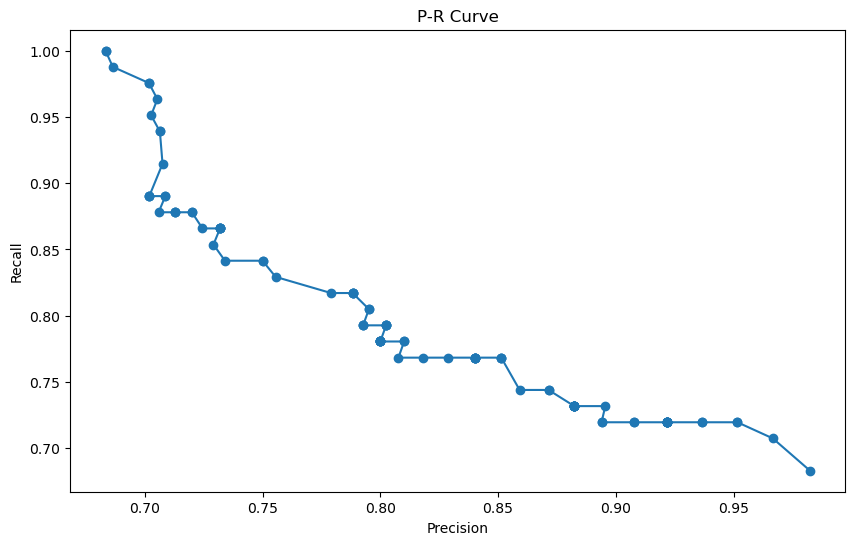

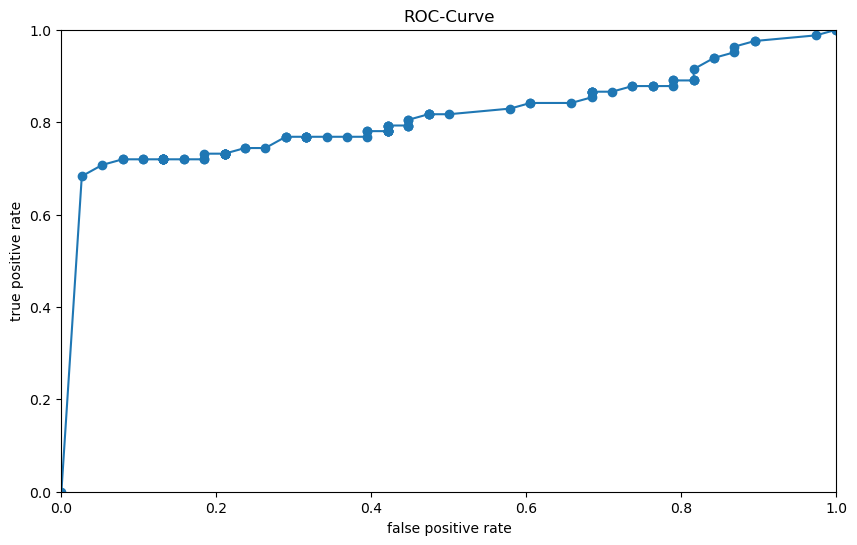

pr-f1对应的f1结果
p	r	f1
[[0.6833 1.     0.8119]
 [0.6864 0.9878 0.81  ]
 [0.7018 0.9756 0.8163]
 [0.7019 0.8902 0.7849]
 [0.7027 0.9512 0.8083]
 [0.7054 0.9634 0.8144]
 [0.7059 0.878  0.7826]
 [0.7064 0.939  0.8063]
 [0.7075 0.9146 0.7979]
 [0.7087 0.8902 0.7892]
 [0.7129 0.878  0.7869]
 [0.72   0.878  0.7912]
 [0.7245 0.8659 0.7889]
 [0.7292 0.8537 0.7865]
 [0.732  0.8659 0.7933]
 [0.734  0.8415 0.7841]
 [0.75   0.8415 0.7931]
 [0.7556 0.8293 0.7907]
 [0.7791 0.8171 0.7976]
 [0.7882 0.8171 0.8024]
 [0.7927 0.7927 0.7927]
 [0.7952 0.8049 0.8   ]
 [0.8    0.7805 0.7901]
 [0.8025 0.7927 0.7975]
 [0.8077 0.7683 0.7875]
 [0.8101 0.7805 0.795 ]
 [0.8182 0.7683 0.7925]
 [0.8289 0.7683 0.7975]
 [0.84   0.7683 0.8025]
 [0.8514 0.7683 0.8077]
 [0.8592 0.7439 0.7974]
 [0.8714 0.7439 0.8026]
 [0.8824 0.7317 0.8   ]
 [0.8939 0.7195 0.7973]
 [0.8955 0.7317 0.8054]
 [0.9077 0.7195 0.8027]
 [0.9219 0.7195 0.8082]
 [0.9365 0.7195 0.8138]
 [0.9516 0.7195 0.8194]
 [0.9667 0.7073 0.8169]
 [0.9825 0.6829 0.80

In [114]:
# 分割训练预测数据集
train_data,test_data = boot_strap_method()
w = [0,0,0,0,0,0,0]
train_data = add_col_1(train_data)
test_data = add_col_1(test_data)

# 梯度下降计算
# 参数设置
learning_rate = 0.004
num_iter = 100000
min_step = 0.05

# 训练模型
w = train_model(train_data,w,learning_rate,num_iter,min_step)
print('参数w',w)

# 计算loss与预测结果
loss, predict = cal_loss_predict(test_data,w)

# 画P-R曲线
p,r,p_r_f1 = plot_pr_curve(test_data,predict)
# 画COR曲线
tp,fp,tp_fp_f1 =  plot_ROC_curve(test_data,predict)

# 打印f1度量

# 去除重复结果
result_pr_f1 = np.column_stack((p, r, p_r_f1))
result_pr_f1 = np.unique(result_pr_f1,axis=0).round(decimals=4)
result_cor_f1 = np.column_stack((tp, fp, tp_fp_f1))
result_cor_f1 = np.unique(result_cor_f1,axis=0).round(decimals=4)
print('pr-f1对应的f1结果')
print('p\tr\tf1')
print(result_pr_f1)
print('cor-f1对应的f1结果')
print('tp\tfp\tf1')
print(result_cor_f1)

**<font color = blue size=4>第五部分:作业提交</font>**

<span style="color:purple">1) 实验报告提交地址 (格式: 学号+姓名+实验四): https://send2me.cn/4-3oEngJ/Qp-icPERnYPjPQ ,
    下周因为国庆假期所以实验课不上，本次实验报告的截止日期为10.8 14:20</span>

<span style="color:purple">2) 实验课件获取地址: https://www.jianguoyun.com/p/Dae3tZUQp5WhChiClp0FIAA</span>